# Multicollinearity Treatment 


In [177]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.model_selection import KFold

#### Reading the Dataset

In [178]:
df = pd.read_csv('Taxi_out_processed.csv')
df = df.drop('Unnamed: 0',1)

In [179]:
df['DAY_OF_WEEK']=df['DAY_OF_WEEK'].astype('object')

In [180]:
num= df.select_dtypes(exclude = 'object')


In [181]:
cat = df.select_dtypes(include = 'object')

In [182]:
cat.head()

,DAY_OF_WEEK,CARRIER_CODE,DEST,DEP_DELAY,Wind,Condition,Region,FLIGHT_TRAFFIC
0,5,DL,SFO,EARLY,W,Fair / Windy,West,Medium
1,5,DL,SLC,EARLY,W,Fair / Windy,West,Medium
2,5,DL,BOS,EARLY,W,Fair / Windy,North East,Medium
3,5,B6,SAV,EARLY,W,Fair / Windy,South,Medium
4,5,B6,ATL,ONTIME,W,Fair / Windy,South,Medium


In [183]:
num = num.drop('TAXI_OUT',1)

#### Variance Inflation Factor

In [184]:
vif = pd.DataFrame()
vif['VIF'] = [VIF(num.values,i) for i in range(num.shape[1])]
vif['Features'] = num.columns
vif.sort_values('VIF',ascending = False)

,VIF,Features
11,inf,FLT_SCH_DEPATURE
12,inf,FLT_SCH_ARRIVAL
14,inf,TOTAL_SCHEDULED
2,1014.297065,SCHEDULED_DEPARTURE
3,983.232909,ACTUAL_DEPATURE
0,915.627559,SCHEDULED_DURATION
1,676.290082,DISTANCE
10,202.755200,Pressure
13,97.244570,SPEED
5,96.141467,Temperature


In [185]:
num = num.drop(['FLT_SCH_DEPATURE','SCHEDULED_DEPARTURE','SCHEDULED_DURATION','Pressure','Temperature','TOTAL_SCHEDULED','SCHEDULED_ARRIVAL','SPEED','FLT_SCH_ARRIVAL'],1)

vif = pd.DataFrame()
vif['VIF'] = [VIF(num.values,i) for i in range(num.shape[1])]
vif['Features'] = num.columns
vif.sort_values('VIF',ascending = False)

,VIF,Features
2,9.271142,Dew Point
4,8.362956,Wind Speed
3,8.104966,Humidity
1,7.895446,ACTUAL_DEPATURE
0,3.022640,DISTANCE
5,1.905617,Wind Gust


In [186]:
num.columns

Index(['DISTANCE', 'ACTUAL_DEPATURE', 'Dew Point', 'Humidity', 'Wind Speed',
       'Wind Gust'],
      dtype='object')

In [187]:
x = pd.concat([num,cat],axis=1)
x.head()

,DISTANCE,ACTUAL_DEPATURE,Dew Point,Humidity,Wind Speed,Wind Gust,DAY_OF_WEEK,CARRIER_CODE,DEST,DEP_DELAY,Wind,Condition,Region,FLIGHT_TRAFFIC
0,4161.75324,414,33,59,24,29,5,DL,SFO,EARLY,W,Fair / Windy,West,Medium
1,3202.58660,414,33,59,24,29,5,DL,SLC,EARLY,W,Fair / Windy,West,Medium
2,300.94658,415,33,59,24,29,5,DL,BOS,EARLY,W,Fair / Windy,North East,Medium
3,1155.50612,417,33,59,24,29,5,B6,SAV,EARLY,W,Fair / Windy,South,Medium
4,1223.09840,418,33,59,24,29,5,B6,ATL,ONTIME,W,Fair / Windy,South,Medium


#### Encoding

In [189]:
labelencoder = LabelEncoder()
for i in x.columns:
    if x[i].dtypes == 'object':
        x[i] = labelencoder.fit_transform(x[i])

In [190]:
x.head()

,DISTANCE,ACTUAL_DEPATURE,Dew Point,Humidity,Wind Speed,Wind Gust,DAY_OF_WEEK,CARRIER_CODE,DEST,DEP_DELAY,Wind,Condition,Region,FLIGHT_TRAFFIC
0,4161.75324,414,33,59,24,29,4,4,50,1,4,3,3,1
1,3202.58660,414,33,59,24,29,4,4,52,1,4,3,3,1
2,300.94658,415,33,59,24,29,4,4,4,1,4,3,1,1
3,1155.50612,417,33,59,24,29,4,3,48,1,4,3,2,1
4,1223.09840,418,33,59,24,29,4,3,1,2,4,3,2,1


In [192]:
inp = x
out = df['TAXI_OUT']

### Scaling the data

In [193]:
sc=StandardScaler()
scaled = sc.fit_transform(inp)
scaled = pd.DataFrame(scaled,columns=inp.columns)
inp = scaled
inp.head()

,DISTANCE,ACTUAL_DEPATURE,Dew Point,Humidity,Wind Speed,Wind Gust,DAY_OF_WEEK,CARRIER_CODE,DEST,DEP_DELAY,Wind,Condition,Region,FLIGHT_TRAFFIC
0,1.656115,-1.539971,0.32428,0.063015,2.369302,2.489449,0.48994,0.693212,1.471587,0.378513,1.406215,-0.918335,0.999212,1.479621
1,0.934515,-1.539971,0.32428,0.063015,2.369302,2.489449,0.48994,0.693212,1.600332,0.378513,1.406215,-0.918335,0.999212,1.479621
2,-1.248444,-1.536107,0.32428,0.063015,2.369302,2.489449,0.48994,0.693212,-1.489541,0.378513,1.406215,-0.918335,-1.002846,1.479621
3,-0.605542,-1.528379,0.32428,0.063015,2.369302,2.489449,0.48994,0.128163,1.342843,0.378513,1.406215,-0.918335,-0.001817,1.479621
4,-0.554692,-1.524515,0.32428,0.063015,2.369302,2.489449,0.48994,0.128163,-1.682658,2.362850,1.406215,-0.918335,-0.001817,1.479621


#### Splitting of Data

In [194]:
xtr,xt,ytr,yt=train_test_split(inp,out,test_size=0.3,random_state=100)
xtr.shape,xt.shape,ytr.shape,yt.shape

((8869, 14), (3802, 14), (8869,), (3802,))

In [195]:
xtr_c=sm.add_constant(xtr)
ols_mod=sm.OLS(ytr,xtr_c).fit()
ols_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     12.32
Date:                Thu, 09 Sep 2021   Prob (F-statistic):           4.49e-29
Time:                        19:39:44   Log-Likelihood:                -28029.
No. Observations:                8869   AIC:                         5.609e+04
Df Residuals:                    8854   BIC:                         5.619e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              19.8988      0.061    328.087      0.000      19.780      20.018
DISTANCE            0.1547      0.081      1.920      0.055      -0.003       0.313
ACTUAL_DEPATURE    -0.0471      0.068     -0.691      0.489      -0.181       0.086
Dew Point           0.2662      0.064      4.164      0.000       0.141       0.392
Humidity           -0.1065      0.062     -1.706      0.088      -0.229       0.016
Wind Speed          0.0878      0.079      1.117      0.264      -0.066       0.242
Wind Gust           0.2120      0.078      2.710      0.007       0.059       0.365
DAY_OF_WEEK         0.1363      0.061      2.227      0.026       0.016       0.256
CARRIER_CODE        0.0553      0.061      0.906      0.365      -0.064       0.175
DEST                0.3124      0.064      4.885      0.000       0.187       0.438
DEP_DELAY          -0.1654      0.062     -2.686      0.007      -0.286      -0.045
Wind               -0.3578      0.062     -5.736      0.000      -0.480      -0.236
Condition           0.2537      0.061      4.169      0.000       0.134       0.373
Region             -0.0753      0.080     -0.946      0.344      -0.231       0.081
FLIGHT_TRAFFIC     -0.3917      0.068     -5.754      0.000      -0.525      -0.258
==============================================================================
Omnibus:                      544.955   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              624.774
Skew:                           0.634   Prob(JB):                    2.15e-136
Kurtosis:                       2.715   Cond. No.                         2.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is no Multicollinearity 


#### BASIC LINEAR REGRESSION MODEL

In [196]:
# basic LR model
lr=LinearRegression()
lr.fit(xtr,ytr)
ypred_tr=lr.predict(xtr)
ypred_t=lr.predict(xt)

In [197]:
tr_r2=r2_score(ytr,ypred_tr)
t_r2=r2_score(yt,ypred_t)
print(tr_r2,t_r2)

#mse
tr_mse=mean_squared_error(ytr,ypred_tr)
t_mse=mean_squared_error(yt,ypred_t)
print(tr_mse,t_mse)

#rmse
tr_rmse=np.sqrt(tr_mse)
t_rmse=np.sqrt(t_mse)
print(tr_rmse,t_rmse)

res_lr=[tr_r2,t_r2,tr_rmse,t_rmse]
res_lr

0.019104792264460824 0.01658740131616232
32.55127154026969 32.18223703059453
5.705372164922258 5.672939011711172


[0.019104792264460824,
 0.01658740131616232,
 5.705372164922258,
 5.672939011711172]

In [198]:
result = pd.DataFrame()
result['Base Model'] = res_lr
result.index=['R2 Train', 'R2 Test','RMSE Train','RMSE Test']
result.T

,R2 Train,R2 Test,RMSE Train,RMSE Test
Base Model,0.019105,0.016587,5.705372,5.672939


# FEATURE ELIMINATION AND TUNING

### Backward Elimination

###### Features for Forward elimination

In [199]:
lr_back=sfs(estimator=lr,k_features=6,scoring='r2',forward=False)
sfs_back=lr_back.fit(xtr,ytr)
fea_back=sfs_back.k_feature_names_
fea_b=list(fea_back)
fea_b

['Dew Point', 'Wind Gust', 'DEST', 'Wind', 'Condition', 'FLIGHT_TRAFFIC']

###### Backward Elimination model

In [200]:
lr=LinearRegression()
lr.fit(xtr[fea_b],ytr)
ypred_tr=lr.predict(xtr[fea_b])
ypred_t=lr.predict(xt[fea_b])

tr_r2=r2_score(ytr,ypred_tr)
t_r2=r2_score(yt,ypred_t)
print(tr_r2,t_r2)

#mse
tr_mse=mean_squared_error(ytr,ypred_tr)
t_mse=mean_squared_error(yt,ypred_t)
print(tr_mse,t_mse)

#rmse
tr_rmse=np.sqrt(tr_mse)
t_rmse=np.sqrt(t_mse)
print(tr_rmse,t_rmse)

res_lr_back=[tr_r2,t_r2,tr_rmse,t_rmse]
res_lr_back

0.016742567341120562 0.0162938507053626
32.62966261029679 32.19184349216506
5.712237968633379 5.673785640307982


[0.016742567341120562,
 0.0162938507053626,
 5.712237968633379,
 5.673785640307982]

### Forward Elimination

###### Features for Forward elimination

In [201]:
lr_forw=sfs(estimator=lr,k_features=6,scoring='r2',forward=True)
sfs_forw=lr_forw.fit(xtr,ytr)
fea_forw=sfs_forw.k_feature_names_
fea_f=list(fea_forw)
fea_f

['Dew Point', 'Wind Gust', 'DEST', 'Wind', 'Condition', 'FLIGHT_TRAFFIC']

###### Forward Elimination model

In [202]:
lr=LinearRegression()
lr.fit(xtr[fea_f],ytr)
ypred_tr=lr.predict(xtr[fea_f])
ypred_t=lr.predict(xt[fea_f])

tr_r2=r2_score(ytr,ypred_tr)
t_r2=r2_score(yt,ypred_t)
print(tr_r2,t_r2)

#mse
tr_mse=mean_squared_error(ytr,ypred_tr)
t_mse=mean_squared_error(yt,ypred_t)
print(tr_mse,t_mse)

#rmse
tr_rmse=np.sqrt(tr_mse)
t_rmse=np.sqrt(t_mse)
print(tr_rmse,t_rmse)

res_lr_forw=[tr_r2,t_r2,tr_rmse,t_rmse]
res_lr_forw

0.016742567341120562 0.0162938507053626
32.62966261029679 32.19184349216506
5.712237968633379 5.673785640307982


[0.016742567341120562,
 0.0162938507053626,
 5.712237968633379,
 5.673785640307982]

### Recursive Feature Elimination

###### Features for Recursive feature elimination

In [203]:
lr = LinearRegression()
rfe = RFE(estimator=lr)   # , scoring='r2')
rfe_model = rfe.fit(xtr,ytr)
rfe_model.ranking_

array([3, 8, 1, 4, 5, 1, 2, 7, 1, 1, 1, 1, 6, 1])

In [204]:
rank= pd.DataFrame()
rank['Feature']=xtr.columns
rank['Feature_Rank']=rfe_model.ranking_
fea_r=rank[rank['Feature_Rank']==1]
fea_r

,Feature,Feature_Rank
2,Dew Point,1
5,Wind Gust,1
8,DEST,1
9,DEP_DELAY,1
10,Wind,1
11,Condition,1
13,FLIGHT_TRAFFIC,1


###### RFE model

In [205]:
lr=LinearRegression()
lr.fit(xtr[fea_r['Feature']],ytr)
ypred_tr=lr.predict(xtr[fea_r['Feature']])
ypred_t=lr.predict(xt[fea_r['Feature']])

tr_r2=r2_score(ytr,ypred_tr)
t_r2=r2_score(yt,ypred_t)
print(tr_r2,t_r2)

#mse
tr_mse=mean_squared_error(ytr,ypred_tr)
t_mse=mean_squared_error(yt,ypred_t)
print(tr_mse,t_mse)

#rmse
tr_rmse=np.sqrt(tr_mse)
t_rmse=np.sqrt(t_mse)
print(tr_rmse,t_rmse)

res_lr_rfe=[tr_r2,t_r2,tr_rmse,t_rmse]
res_lr_rfe

0.0175730763946772 0.01721480466837999
32.602101943769135 32.16170521778078
5.709825036178353 5.671129095495956


[0.0175730763946772, 0.01721480466837999, 5.709825036178353, 5.671129095495956]

## Feature Elimination Results

In [206]:
result = pd.DataFrame()
result['Full Model'] = res_lr
result['Backward Elimination'] = res_lr_back
result['Forward Selection'] = res_lr_forw
result['RFE'] = res_lr_rfe
result.index=['R2 Train', 'R2 Test','RMSE Train','RMSE Test']

In [207]:
result

,Full Model,Backward Elimination,Forward Selection,RFE
R2 Train,0.019105,0.016743,0.016743,0.017573
R2 Test,0.016587,0.016294,0.016294,0.017215
RMSE Train,5.705372,5.712238,5.712238,5.709825
RMSE Test,5.672939,5.673786,5.673786,5.671129


# Model Selection

#### Basic LR Model

In [208]:
err_tr =[]
err_t =[]
r2_tr=[]
r2_t =[]

In [209]:
lr=LinearRegression()
lr.fit(xtr,ytr)

y_pred_train = lr.predict(xtr)
y_pred_test = lr.predict(xt)

train_r2 = r2_score(ytr,y_pred_train)
r2_tr.append(train_r2)
test_r2 = r2_score(yt,y_pred_test)
r2_t.append(test_r2)

train_mse = mean_squared_error(ytr,y_pred_train)
test_mse = mean_squared_error(yt,y_pred_test)

train_rmse = np.sqrt(train_mse)
err_tr.append(train_rmse)
test_rmse = np.sqrt(test_mse)
err_t.append(test_rmse)

res_lr = [train_r2,test_r2,train_rmse,test_rmse]
res_lr

[0.019104792264460824,
 0.01658740131616232,
 5.705372164922258,
 5.672939011711172]

#### LASSO

###### GridSearchCV

In [210]:
para={'alpha':[0.01,0.02,0.1,0.2,0.001]}
l=Lasso(normalize=True)

lcv=GridSearchCV(l,para,cv=5,scoring='r2')
lcv.fit(xtr,ytr)

GridSearchCV(cv=5, estimator=Lasso(normalize=True),
             param_grid={'alpha': [0.01, 0.02, 0.1, 0.2, 0.001]}, scoring='r2')

In [211]:
lcv.best_params_

{'alpha': 0.001}

###### Lasso Model Bulding

In [212]:
las=Lasso(alpha=0.001) 
las.fit(xtr,ytr)


y_pred_train = las.predict(xtr)
y_pred_test = las.predict(xt)

train_r2 = r2_score(ytr,y_pred_train)
r2_tr.append(train_r2)
test_r2 = r2_score(yt,y_pred_test)
r2_t.append(test_r2)

train_mse = mean_squared_error(ytr,y_pred_train)  #Train MSE
test_mse = mean_squared_error(yt,y_pred_test)

train_rmse = np.sqrt(train_mse)
err_tr.append(train_rmse)
test_rmse = np.sqrt(test_mse)
err_t.append(test_rmse)

res_lasso = [train_r2,test_r2,train_rmse,test_rmse]
res_lasso

[0.019104219259731603,
 0.01661905387161433,
 5.705373831361613,
 5.67284771510699]

#### RIDGE

###### GridSearchCV

In [213]:
para={'alpha':[0.01,0.02,0.1,0.2,0.001]}
l=Ridge(normalize=True)

lcv=GridSearchCV(l,para,cv=5,scoring='r2')
lcv.fit(xtr,ytr)

GridSearchCV(cv=5, estimator=Ridge(normalize=True),
             param_grid={'alpha': [0.01, 0.02, 0.1, 0.2, 0.001]}, scoring='r2')

In [214]:
lcv.best_params_

{'alpha': 0.1}

###### RIDGE Model Bulding

In [215]:
rid=Ridge(alpha=0.11,normalize=True)
rid.fit(xtr,ytr)


y_pred_train = rid.predict(xtr)
y_pred_test = rid.predict(xt)

train_r2 = r2_score(ytr,y_pred_train)
r2_tr.append(train_r2)
test_r2 = r2_score(yt,y_pred_test)
r2_t.append(test_r2)

train_mse = mean_squared_error(ytr,y_pred_train)  #Train MSE
test_mse = mean_squared_error(yt,y_pred_test)

train_rmse = np.sqrt(train_mse)
err_tr.append(train_rmse)
test_rmse = np.sqrt(test_mse)
err_t.append(test_rmse)

res_ridge = [train_r2,test_r2,train_rmse,test_rmse]
res_ridge

[0.018888124572056797,
 0.016804479943187123,
 5.706002253414582,
 5.6723128545011]

### ELASTIC NET

###### GridSearchCV

In [216]:
para={'alpha':[0.01,0.02,0.1,0.2,0.001]}
l=ElasticNet(normalize=True)

lcv=GridSearchCV(l,para,cv=5,scoring='r2')
lcv.fit(xtr,ytr)

GridSearchCV(cv=5, estimator=ElasticNet(normalize=True),
             param_grid={'alpha': [0.01, 0.02, 0.1, 0.2, 0.001]}, scoring='r2')

In [217]:
lcv.best_params_

{'alpha': 0.001}

###### ELASTIC NET Model Bulding

In [218]:
enet=ElasticNet(alpha=0.001,normalize=True)
enet.fit(xtr,ytr)


y_pred_train = enet.predict(xtr)
y_pred_test = enet.predict(xt)

train_r2 = r2_score(ytr,y_pred_train)
r2_tr.append(train_r2)
test_r2 = r2_score(yt,y_pred_test)
r2_t.append(test_r2)

train_mse = mean_squared_error(ytr,y_pred_train)  #Train MSE
test_mse = mean_squared_error(yt,y_pred_test)

train_rmse = np.sqrt(train_mse)
err_tr.append(train_rmse)
test_rmse = np.sqrt(test_mse)
err_t.append(test_rmse)

res_elastic = [train_r2,test_r2,train_rmse,test_rmse]
res_elastic

[0.005519404223552571,
 0.0055347762941465595,
 5.744745973478337,
 5.704729165862823]

#### KNeighborsRegressor

In [219]:
knn= KNeighborsRegressor(n_neighbors=6,weights='uniform')

y_pred_train = knn.fit(xtr,ytr.values.ravel()).predict(xtr)
y_pred_test= knn.fit(xtr,ytr.values.ravel()).predict(xt)

train_r2 = r2_score(ytr,y_pred_train)
r2_tr.append(train_r2)
test_r2 = r2_score(yt,y_pred_test)
r2_t.append(test_r2)

train_mse = mean_squared_error(ytr,y_pred_train)  #Train MSE
test_mse = mean_squared_error(yt,y_pred_test)

train_rmse = np.sqrt(train_mse)
err_tr.append(train_rmse)
test_rmse = np.sqrt(test_mse)
err_t.append(test_rmse)

res_svr = [train_r2,test_r2,train_rmse,test_rmse]
res_svr

[0.27931361187468284,
 -0.036325795028143926,
 4.890416322709508,
 5.823557726617146]

### Light GBM

In [220]:
from lightgbm import LGBMRegressor
lgb_train= lgb.Dataset(xtr, label = ytr)
lgb_eval= lgb.Dataset(xtr,ytr, reference= lgb_train)
params = {'n_estimators':500,
          'max_depth':5,
          'learning_rate': 0.0010,
          'boosting_type': 'gbdt',
          'weights': 'uniform',
          'n_neighbors': 6,
          'num_leaves': 60}

y_pred_train = lgb.train(params, lgb_train, 100).predict(xtr)
y_pred_test = lgb.train(params, lgb_train, 100).predict(xt)

train_r2 = r2_score(ytr,y_pred_train)
r2_tr.append(train_r2)
test_r2 = r2_score(yt,y_pred_test)
r2_t.append(test_r2)

train_mse = mean_squared_error(ytr,y_pred_train)  #Train MSE
test_mse = mean_squared_error(yt,y_pred_test)

train_rmse = np.sqrt(train_mse)
err_tr.append(train_rmse)
test_rmse = np.sqrt(test_mse)
err_t.append(test_rmse)

res_light = [train_r2,test_r2,train_rmse,test_rmse]
res_light


[LightGBM] [Warning] Unknown parameter: weights
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: weights
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 8869, number of used features: 14
[LightGBM] [Info] Start training from score 19.903935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: weights
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] Unknown parameter: weights
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] Unknown parameter: weights
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 8869, number of used features: 14
[LightGBM] [Info] Start training from score 19.903935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[0.06357537685348791,
 0.04461043737532966,
 5.574540628476989,
 5.591527651122083]

### Support Vector Regression

In [221]:
reg= SVR(kernel='rbf')
reg.fit(xtr,ytr.values.ravel())
y_pred_train= reg.predict(xtr)
y_pred_test= reg.predict(xt)

train_r2 = r2_score(ytr,y_pred_train)
r2_tr.append(train_r2)
test_r2 = r2_score(yt,y_pred_test)
r2_t.append(test_r2)

train_mse = mean_squared_error(ytr,y_pred_train)  #Train MSE
test_mse = mean_squared_error(yt,y_pred_test)

train_rmse = np.sqrt(train_mse)
err_tr.append(train_rmse)
test_rmse = np.sqrt(test_mse)
err_t.append(test_rmse)

res_svr = [train_r2,test_r2,train_rmse,test_rmse]
res_svr

[0.10046077120604446,
 0.03366363114660598,
 5.463648183847014,
 5.623470136141533]

### MODEL RESULTS

In [222]:
result1 = pd.DataFrame()
result1['LR Model'] = res_lr
result1['Lasso'] = res_lasso
result1['Ridge'] = res_ridge
result1['Elastic'] = res_elastic
result1['Light GBM'] = res_light
result1['SVR'] = res_svr
result1.index=['R2 Train', 'R2 Test','RMSE Train','RMSE Test']
result1

,LR Model,Lasso,Ridge,Elastic,Light GBM,SVR
R2 Train,0.019105,0.019104,0.018888,0.005519,0.063575,0.100461
R2 Test,0.016587,0.016619,0.016804,0.005535,0.044610,0.033664
RMSE Train,5.705372,5.705374,5.706002,5.744746,5.574541,5.463648
RMSE Test,5.672939,5.672848,5.672313,5.704729,5.591528,5.623470


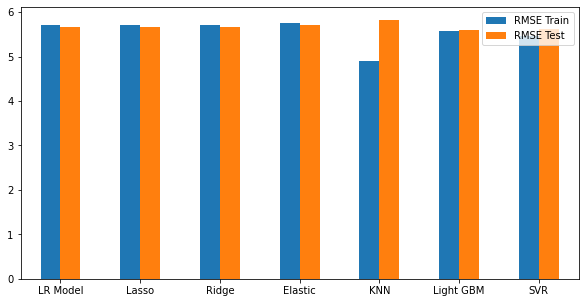

In [223]:
labels=['LR Model','Lasso','Ridge','Elastic','KNN','Light GBM','SVR']
df = pd.DataFrame({'RMSE Train':err_tr,'RMSE Test':err_t}, index=labels)
ax = df.plot.bar(rot=0,figsize=(10,5))

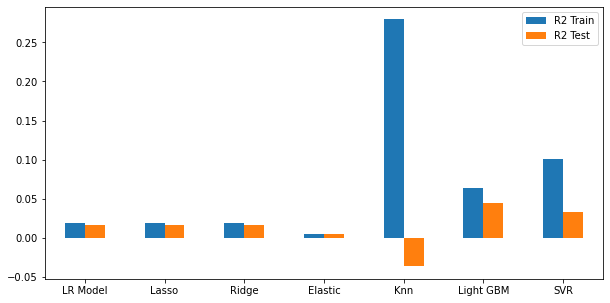

In [224]:
labels=['LR Model','Lasso','Ridge','Elastic','Knn','Light GBM','SVR']
df = pd.DataFrame({'R2 Train':r2_tr,'R2 Test':r2_t}, index=labels)
ax = df.plot.bar(rot=0,figsize=(10,5))